In [25]:
import numpy as np
%matplotlib inline                                 
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace  
import scipy.sparse as sparse
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
np.random.seed(1234)

Load newsgroup data and use countvectorize to get data into 'bag of words' format

In [26]:
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'))

newsgroups_test = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'))


# Labels 
y_train = newsgroups_train.target
print('y_train dimensions:\n', y_train.shape, '\nFirst elements:\n', y_train[:5])

y_test = newsgroups_test.target
print('y_test dimensions:\n', y_test.shape, '\nFirst elements:\n', y_test[:5])


count_vect = CountVectorizer(binary=True, stop_words=['in','of','at','a','the'])
x_train = count_vect.fit_transform(newsgroups_train.data)
x_train.shape
x_test = count_vect.transform(newsgroups_test.data)
x_test.shape

y_train dimensions:
 (11314,) 
First elements:
 [ 7  4  4  1 14]
y_test dimensions:
 (7532,) 
First elements:
 [ 7  5  0 17 19]


(7532, 101627)

Different preprocessing techniques

In [6]:
count_vect_bigrams = CountVectorizer(binary=True, ngram_range=(1, 2), stop_words=['in','of','at','a','the'])
x_train_bigrams = count_vect_bigrams.fit_transform(newsgroups_train.data)
print(x_train_bigrams.shape)
x_test_bigrams = count_vect_bigrams.transform(newsgroups_test.data)
print(x_test_bigrams.shape)

(11314, 999239)
(7532, 999239)


In [27]:
freq_vect = CountVectorizer(ngram_range=(1, 2), stop_words=['in','of','at','a','the'])
x_train_freq = freq_vect.fit_transform(newsgroups_train.data)
print(x_train_freq.shape)
x_test_freq = freq_vect.transform(newsgroups_test.data)
print(x_test_freq.shape)

(11314, 999239)
(7532, 999239)


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words=['in','of','at','a','the'])
type(newsgroups_test.data)
x_train_tfidf = tfidf_vect.fit_transform(newsgroups_train.data)
print(x_train_tfidf.shape)
x_test_tfidf = tfidf_vect.transform(newsgroups_test.data)
print(x_test_tfidf.shape)

(11314, 999239)
(7532, 999239)


Here are the cross validation functions cross_validation_split and kfoldCV


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


def cross_validation_split(x_train,y_train,k_folds):
  
  #get size of validation set
  n_val = x_train.shape[0] // k_folds
  #initialize lists and dictionaries to store data and labels for different folds
  full_train = []
  full_val = []
  #labels are stored in dictionary to prevent rounding from k_folds to store different sized arrays
  #list works with data because it is in list of csr matrix
  y_cv_train = {}
  y_cv_val = {}
  
  
  for f in range(k_folds):
      tr_inds = []
      #get the validation indexes
      val_inds = list(range(f * n_val, (f+1)*n_val))
      #get the train indexes
      if f > 0:
          tr_inds = list(range(f*n_val))
      if f < k_folds - 1:
          tr_inds = tr_inds + list(range((f+1)*n_val, x_train.shape[0]))
      
      #store training data
      x_cv_train = x_train.tocsr()[tr_inds,:]
      y_cv_train['fold_'+str(f)] = np.take(y_train,tr_inds)
      #store validation data
      x_cv_val = x_train.tocsr()[val_inds,:]
      y_cv_val['fold_'+str(f)] = np.take(y_train,val_inds)
      

      full_train.append(x_cv_train)
      full_val.append(x_cv_val)
  return full_train, full_val, y_cv_train, y_cv_val


#runs the cross validation
def kfoldCV(full_train,full_val,y_cv_train,y_cv_val,model):
  k_folds = len(full_train)
  acc = []
  for i in range(k_folds):
    model.fit(full_train[i],y_cv_train['fold_'+str(i)])
    acc.append(accuracy_score(y_cv_val['fold_'+str(i)], model.predict(full_val[i])))
  return acc


Here we run 5-fold validation on each of the preprocessed datasets and report the average accuracies


In [ ]:
train_set, val_set, y_cv_train, y_cv_val = cross_validation_split(x_train,y_train,k_folds=5)

logistic_reg = LogisticRegression(C=1, max_iter=1000)

accuracies = kfoldCV(train_set,val_set,y_cv_train,y_cv_val,logistic_reg)
print(accuracies)

preprocess_x = [x_train, x_train_bigrams, x_train_freq, x_train_tfidf]
logistic_reg = LogisticRegression(C=1, max_iter=1000)
#tfidf has best accuracy
for prepro in preprocess_x:

  train_set, val_set, y_cv_train, y_cv_val = cross_validation_split(prepro,y_train,k_folds=5)  
  accuracies = kfoldCV(train_set,val_set,y_cv_train,y_cv_val,logistic_reg)
  print('The accuracies for each fold are: ',accuracies)
  print('Avg accuracy: ',np.mean(accuracies))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

c_list = [0.01,0.1,1,10,100]
max_iter_list = [1000]
mean_acc_list = []
train_set, val_set, y_cv_train, y_cv_val = cross_validation_split(x_train,y_train,k_folds=5)

for c in c_list:
  for max_i in max_iter_list:
    #hyperparameter tuning
    logistic_reg = LogisticRegression(C=c,max_iter=max_i)
    acc = kfoldCV(train_set,val_set,y_cv_train,y_cv_val,logistic_reg)
    mean_acc = np.mean(acc)
    mean_acc_list.append(mean_acc)
    print('For hyperparameters C=',c,' and max_iter=',max_i,'5-fold CV accuracy is ',mean_acc)


For hyperparameters C= 0.001  and solver= lbfgs 5-fold CV accuracy is  0.05720601237842617
1.0
1.0
For hyperparameters C= 0.001  and solver= saga 5-fold CV accuracy is  0.057736516357206016
For hyperparameters C= 0.01  and solver= lbfgs 5-fold CV accuracy is  0.22740937223695848
1.0
1.0
For hyperparameters C= 0.01  and solver= saga 5-fold CV accuracy is  0.2271441202475685
For hyperparameters C= 0.1  and solver= lbfgs 5-fold CV accuracy is  0.5662245800176834
1.0
1.0
For hyperparameters C= 0.1  and solver= saga 5-fold CV accuracy is  0.5660477453580902
For hyperparameters C= 1  and solver= lbfgs 5-fold CV accuracy is  0.7029177718832892
1.0
1.0
For hyperparameters C= 1  and solver= saga 5-fold CV accuracy is  0.7033598585322723
For hyperparameters C= 10  and solver= lbfgs 5-fold CV accuracy is  0.7395225464190982
1.0
1.0
For hyperparameters C= 10  and solver= saga 5-fold CV accuracy is  0.7400530503978779
For hyperparameters C= 100  and solver= lbfgs 5-fold CV accuracy is  0.7472148541

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


For hyperparameters C= 1000  and solver= saga 5-fold CV accuracy is  0.7489832007073385
[[0.05720601 0.22740937 0.56622458 0.70291777 0.73952255 0.74721485
  0.75004421]
 [0.05773652 0.22714412 0.56604775 0.70335986 0.74005305 0.74721485
  0.7489832 ]]
[[0.02184033 0.02024081 0.01726607 0.01001499 0.00662481 0.00580734
  0.00536803]
 [0.02267797 0.02075718 0.01794589 0.01010049 0.00644901 0.00595358
  0.00527104]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

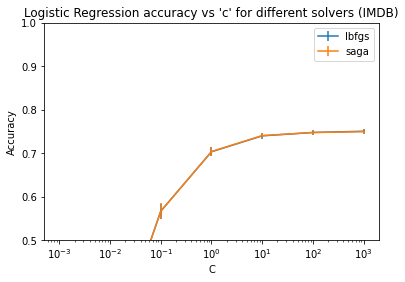

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



c_list = [0.001,0.01,0.1,1,10,100,1000]
max_iter_list = [1000]
solvers = ['lbfgs','saga']
mean_accs = np.zeros([len(solvers), len(c_list)])
std_accs = np.zeros([len(solvers), len(c_list)])

train_set, val_set, y_cv_train, y_cv_val = cross_validation_split(x_train_tfidf,y_train,k_folds=5)


for i,c in enumerate(c_list):
  for j,sol in enumerate(solvers):
    #hyperparameter tuning
    #print(c)
    #print(max_i)
    if sol == 'saga':
      train_set_sc = [csr_mat / csr_mat.max() for csr_mat in train_set]
      print(train_set_sc[0].max())
      val_set_sc = [csr_mat / csr_mat.max() for csr_mat in val_set]
      print(val_set_sc[0].max())
      logistic_reg = LogisticRegression(C=c,max_iter=1000,solver=sol)
      acc = kfoldCV(train_set_sc,val_set_sc,y_cv_train,y_cv_val,logistic_reg)
    else:
      logistic_reg = LogisticRegression(C=c,max_iter=1000,solver=sol)
      acc = kfoldCV(train_set,val_set,y_cv_train,y_cv_val,logistic_reg)
    #print(acc)
    mean_acc = np.mean(acc)
    mean_accs[j,i] = mean_acc
    std_accs[j,i] = np.std(acc)

    print('For hyperparameters C=',c,' and solver=',sol,'5-fold CV accuracy is ',mean_acc)

import matplotlib.pyplot as plt
from google.colab import files
print(mean_accs)
print(std_accs)

plt.errorbar(c_list,mean_accs[0],std_accs[0],label='lbfgs')
plt.errorbar(c_list,mean_accs[1],std_accs[1],label='saga')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.title('Logistic Regression accuracy vs \'c\' for different solvers (IMDB)')
plt.legend()
plt.savefig('logreg_hyper1.png')
files.download('logreg_hyper1.png') 
#lbfgs with 0.75
#saga with 74.89
#both optimal at c=1000
#makes sense less regularization because model must be complex given multinomial

Running on test set (switch preprocessing method to whichever set you want to train your data on)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), stop_words=['in','of','at','a','the'],use_idf=True)
type(newsgroups_test.data)
x_train_tfidf = tfidf_vect.fit_transform(newsgroups_train.data)
print(x_train_tfidf.shape)
x_test_tfidf = tfidf_vect.transform(newsgroups_test.data)
print(x_test_tfidf.shape)

def confusion_matrix(y, yh):
    n_classes = np.max(y) + 1
    c_matrix = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
        #(y==c1)*(yh==c2) is 1 when both conditions are true or 0
            c_matrix[c1, c2] = np.sum((y==c1)*(yh==c2))
    return c_matrix

#C=10 and 1000 are close enough in accuracy and it seems like C=1000 takes forever to run
logistic_reg = LogisticRegression(C=10,max_iter=1000)
logistic_reg.fit(x_train_tfidf,y_train)
yhat = logistic_reg.predict(x_test_tfidf)
acc_test = accuracy_score(y_test,yhat)
print(acc_test)

#c_mat = confusion_matrix(y_test, yhat)

#print(c_mat)

(11314, 999239)
(7532, 999239)
0.6841476367498672


Getting average recalls and precisions since it's multiclass

In [17]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score



c_mat = confusion_matrix(y_test, yhat)

recall = np.diag(c_mat) / np.sum(c_mat, axis = 1)
precision = np.diag(c_mat) / np.sum(c_mat, axis = 0)

print(np.mean(recall))
print(np.mean(precision))



0.6715901832556015
0.6860747009121253


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

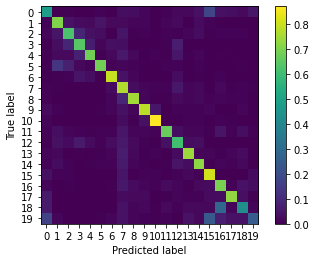

In [31]:
from sklearn.metrics import plot_confusion_matrix
from google.colab import files

disp = plot_confusion_matrix(logistic_reg,x_test_tfidf,y_test,include_values=False,normalize='true')
#disp.plot()
plt.savefig('confusion_mat_newsg.png')
files.download('confusion_mat_newsg.png') 

Graph that shows accuracy vs training set size

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

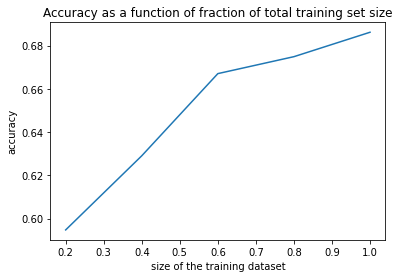

In [24]:
# Split the training set into different sizes
def size_split(x_train, y_train, n_test_list):
  x_train_sizes_list = []
  y_train_sizes_list = []
  for n in n_test_list:
    num_instances = x_train.shape[0]
    inds = np.random.permutation(num_instances)
    n_test = int(num_instances*n) - 1
    
    #shuffle the data
    x_train_sizes = x_train.tocsr()[inds,]
    y_train_sizes = y_train[inds]

    #store data
    x_train_sizes = x_train_sizes[:n_test,:]
    x_train_sizes_list.append(x_train_sizes)

    y_train_sizes = y_train_sizes[:n_test]
    y_train_sizes_list.append(y_train_sizes)

  return x_train_sizes_list, y_train_sizes_list


n_sizes = [0.2, 0.4, 0.6, 0.8, 1]
x_train_sizes_list, y_train_sizes_list = size_split(x_train_tfidf, y_train, n_test_list=n_sizes)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

err_test = []

for i in range(len(x_train_sizes_list)):

    logistic_reg = LogisticRegression(multi_class='multinomial', C=100, max_iter = 1000)
    logistic_reg.fit(x_train_sizes_list[i], y_train_sizes_list[i])
    err_test.append(accuracy_score(y_test, logistic_reg.predict(x_test_tfidf)))

plt.plot(n_sizes, err_test, '-')
#plt.legend()
plt.xlabel('size of the training dataset')
plt.ylabel('accuracy')
plt.title('Accuracy as a function of fraction of total training set size')
plt.savefig('accvssize_newsg.png')
files.download('accvssize_newsg.png') 
